CNN is very successful in image classification. But it can also be used in NLP classification problem. For this project I used IMDb, Amazon, and Yelp. Each review has a score which is either 0 or 1, where 0 is for a negative sentiment and 1 for a positive sentiment. 

In [22]:
import os
import time
import numpy as np
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
from keras.applications import VGG19
import os
import time
from keras.preprocessing import image

from keras.applications.resnet50 import ResNet50, preprocess_input

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For this, all the reviews are concatenated and I got one final data as follows.

In [24]:
import pandas as pd

filepath_dict = {'yelp': '/content/drive/My Drive/sentiment_labelled_sentences/yelp_labelled.txt','amazon': '/content/drive/My Drive/sentiment_labelled_sentences/amazon_cells_labelled.txt','imdb':'/content/drive/My Drive/sentiment_labelled_sentences/imdb_labelled.txt'}       
                  
                  
                  
df_list = []
for source, filepath in filepath_dict.items():
   df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
   # Add another column filled with the source name
   df['source'] = source 
   df_list.append(df)
df = pd.concat(df_list)
print(df.head())

                                            sentence  label source
0                           Wow... Loved this place.      1   yelp
1                                 Crust is not good.      0   yelp
2          Not tasty and the texture was just nasty.      0   yelp
3  Stopped by during the late May bank holiday of...      1   yelp
4  The selection on the menu was great and so wer...      1   yelp


Keras :
Tokenizer: Vectorize a text corpus into a list of integers. 
Additionally, a maxlen parameter is used to specify how long the sequences should be. This cuts sequences that exceed that number.

In [25]:
from sklearn.model_selection import train_test_split             

from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences
df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.3,  
                                                random_state=0)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1                          

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [26]:
import numpy as np

def matrix(filepath, word_index, dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    matrix = np.zeros((vocab_size, dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                matrix[idx] = np.array(vector, dtype=np.float32)[:dim]

    return matrix

GloVe:To obtain word embeddings I used GloVe(Global Vectors for Word Representation) developed by the Stanford NLP Group.

In [31]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix("/content/drive/My Drive/Colab_Notebooks/glove/glove.6B.50d.txt" ,tokenizer.word_index, embedding_dim)

Training a CNN Model

In [32]:
from keras.models import Sequential
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
75/75 [==============================] - 1s 17ms/step - loss: 0.6834 - accuracy: 0.5507 - val_loss: 0.6602 - val_accuracy: 0.6560
Epoch 2/10
75/75 [==============================] - 1s 15ms/step - loss: 0.4921 - accuracy: 0.8413 - val_loss: 0.4922 - val_accuracy: 0.7560
Epoch 3/10
75/75 [==============================] - 1s 15ms/step - loss: 0.1677 - accuracy: 0.9613 - val_loss: 0.4737 - val_accuracy: 0.7880
Epoch 4/10
75/75 [==============================] - 1s 15ms/step - loss: 0.0420 - accuracy: 0.9880 - val_loss: 0.5064 - val_accuracy: 0.8040
Epoch 5/10
75/75 [==============================] - 1s 15ms/step - loss: 0.0102 - accuracy: 0.9987 - val_loss: 0.5654 - val_accuracy: 0.7840
Epoch 6/10
75/75 [==============================] - 1s 15ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5985 - val_accuracy: 0.7880
Epoch 7/10
75/75 [==============================] - 1s 15ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.6421 - val_accuracy: 0.7840
Epoch 8/10
75

From the below graphs can be understood that model accuracy of training is higher than test. Train is 1 whereas test is 0.796. The model is overfitting the data. Loss plot is also showing that the though model loss is decreasing in each epoch but test set loss after decreasing started increasing.

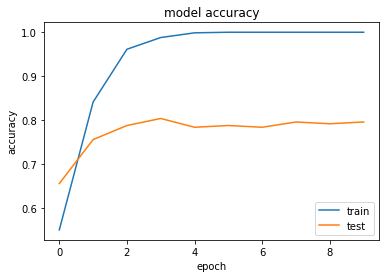

In [34]:
import matplotlib.pyplot as plt
# summarize model for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()

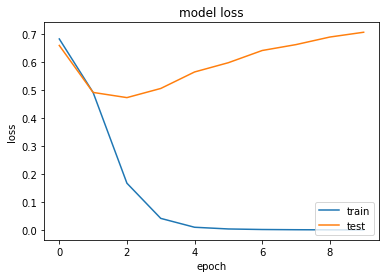

In [35]:
import matplotlib.pyplot as plt
# summarize model for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()

In [40]:
y_pred=model.predict(X_test)
#y_pred=y_pred.round()
THRESHOLD = 0.5
preds = np.where(y_pred > THRESHOLD, 1, 0)

In [42]:
from sklearn.metrics import confusion_matrix
cm_an=confusion_matrix(y_test, preds)
cm_an

array([[100,  20],
       [ 31,  99]])

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
specificity = tn / (tn+fp)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print("Neural network specificity, Precision, Recall(Sensitivity), accuracy are", specificity, Precision, Recall)

Neural network specificity, Precision, Recall(Sensitivity), accuracy are 0.8333333333333334 0.8319327731092437 0.7615384615384615


CONCLUSION:
CNN is used to NLP problemand classification is acheived. Train accuracy is 1 whereas test is 0.796. This suggesting model is overfitting. Before applying to any outside data this problem should be addressed. Neural network specificity, Precision, Recall(Sensitivity), accuracy are 0.833, 0.83 and 0.76.